## Machine Learning exam, Andrea Milici

In [78]:
from preprocessing.Preprocessor import Preprocessor
import numpy as np
import matplotlib.pyplot as plt


In [79]:
# La classe Preprocessor è adibita alla preparazione dei dati per il training del modello cioè a:
# - Caricare i dati
# - Visualizzare i dati
# - Normalizzare i dati

preprocessing = Preprocessor() # transform_to_2d= True di default
data = preprocessing.load_data("/auto_atlas/atlas/atlas_gen_fs/amilici/other_samples/ml_exam_dataset/data.json")
# Visualizzazione dei dati

print("Data shape: ", data.shape)
print("Data columns ", data.columns,"\n")
print("Data info: ", data.info())
print(data.head())


Data shape:  (3000, 3)
Data columns  Index(['sequence', 'label', 'quench'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  3000 non-null   object
 1   label     3000 non-null   int64 
 2   quench    300 non-null    object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
Data info:  None
                                            sequence  label quench
0  [[[20.709092344780334, 21.10805148255272, 21.4...      0    NaN
1  [[[19.802651670136296, 20.50515451242753, 20.9...      0    NaN
2  [[[20.093307776144727, 21.719389214744755, 20....      0    NaN
3  [[[21.012905318373452, 21.29382500187407, 20.4...      0    NaN
4  [[[22.930529765636, 19.758584723579446, 21.709...      0    NaN


Quench:  [{'step': 6, 'pixel': [6, 10], 'temp': 24.42123477741411}, {'step': 7, 'pixel': [13, 13], 'temp': 24.976830586647395}, {'step': 18, 'pixel': [3, 13], 'temp': 24.96900474754216}, {'step': 18, 'pixel': [13, 12], 'temp': 24.875923623060395}]


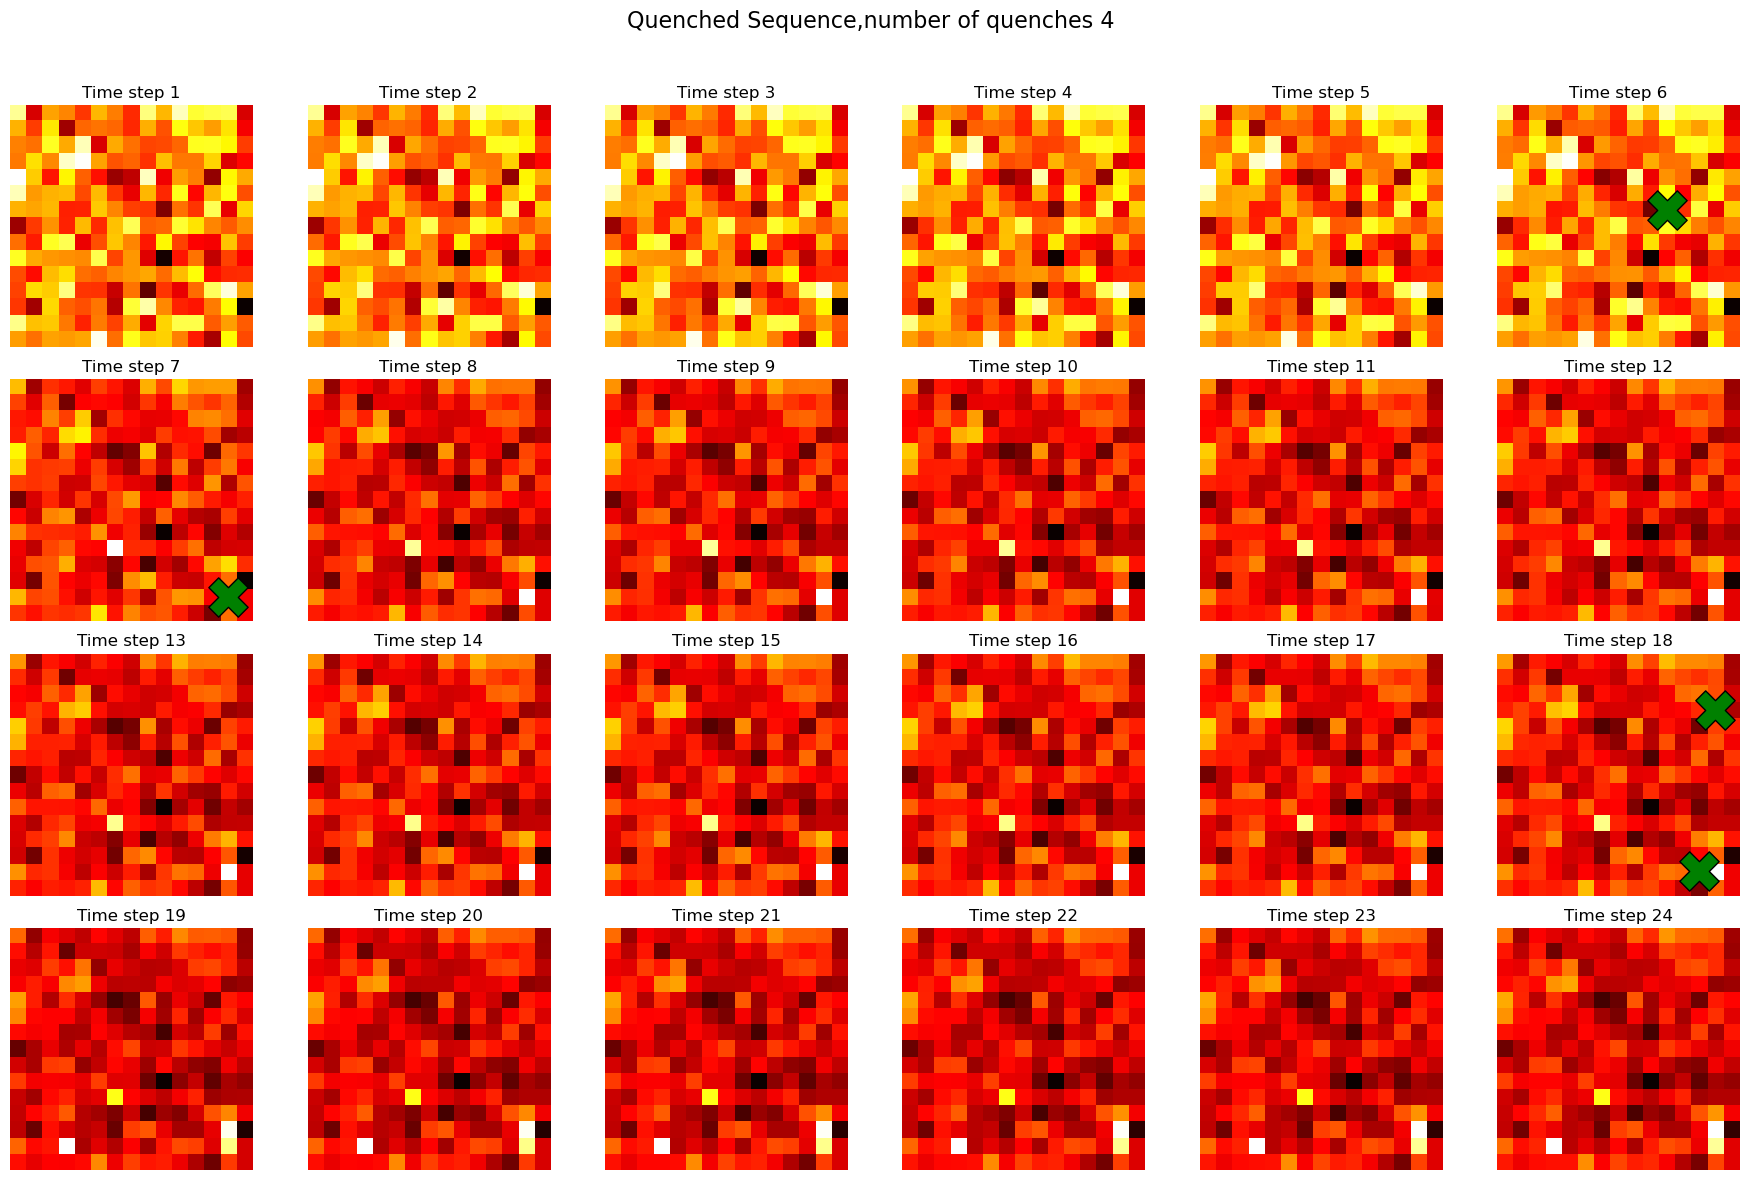

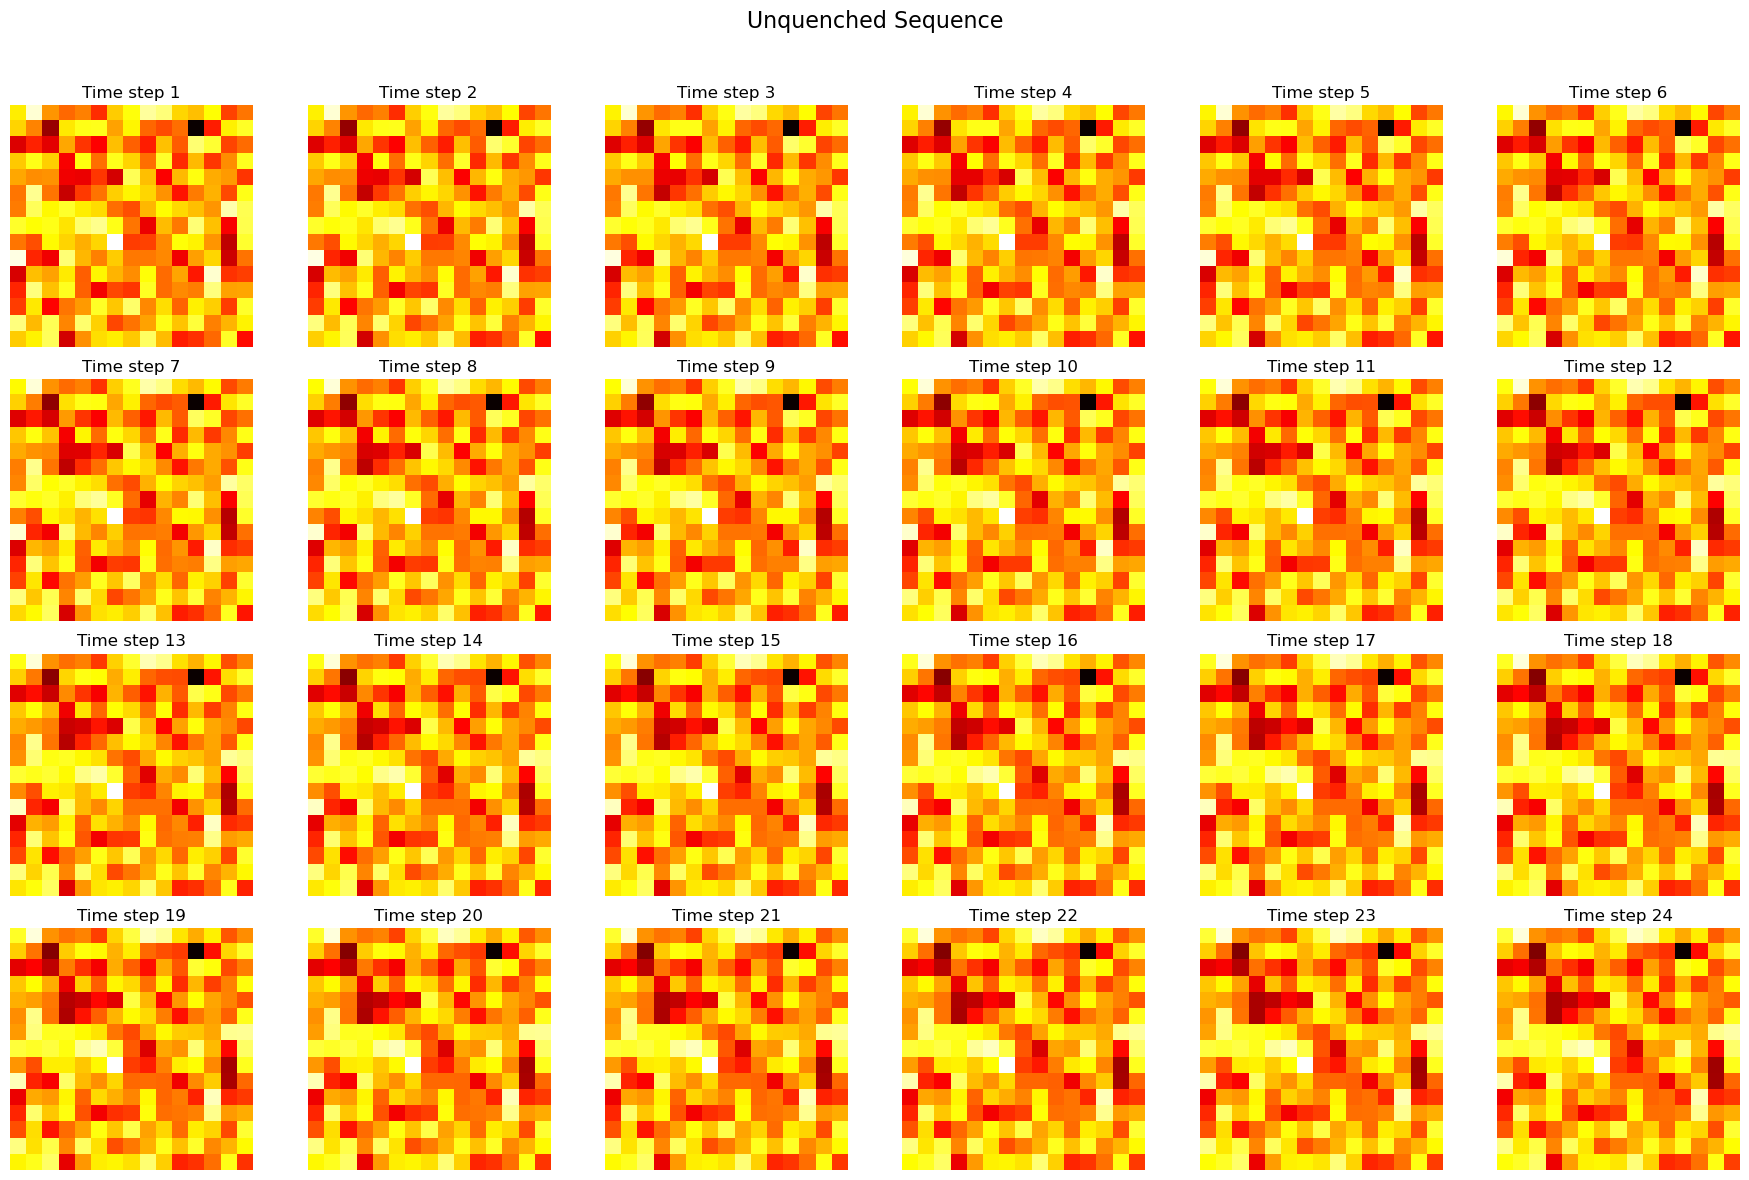

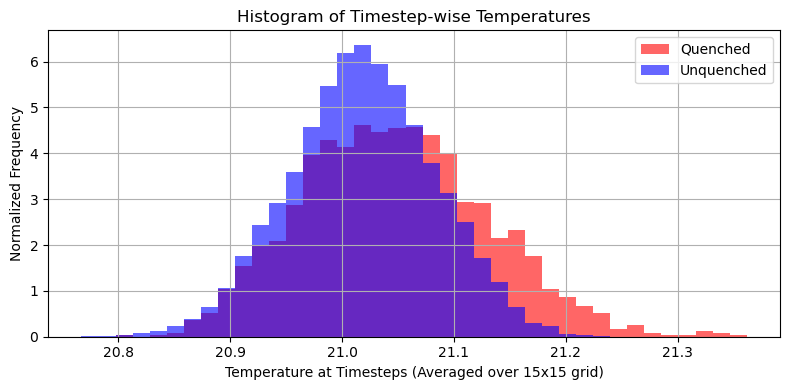

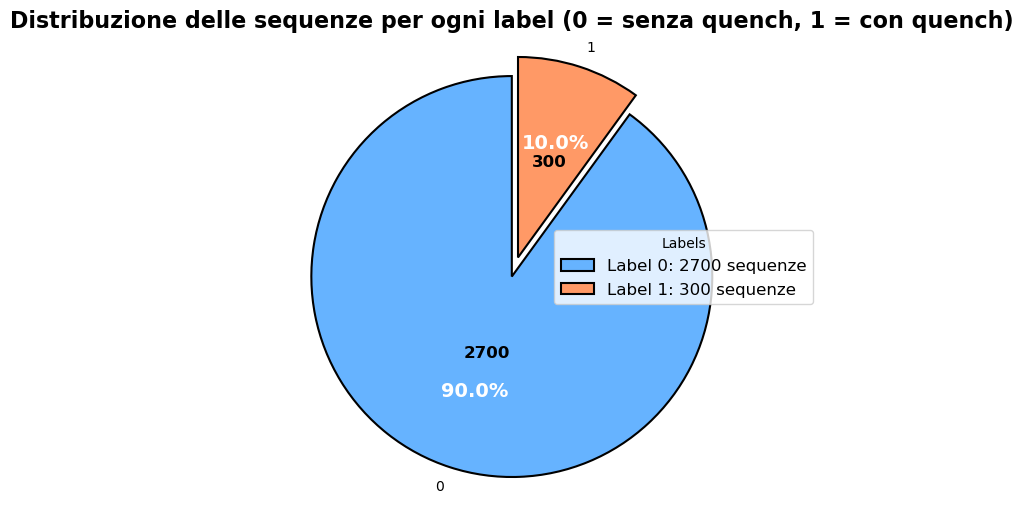

In [80]:
# Vediamo una sequenza di heatmap con label == 1
preprocessing.visualize_sequence(data,quenched=True,debug=True)
# Vediamo una sequenza di heatmap con label == 0
preprocessing.visualize_sequence(data,quenched=False)
preprocessing.more_data_exploration()

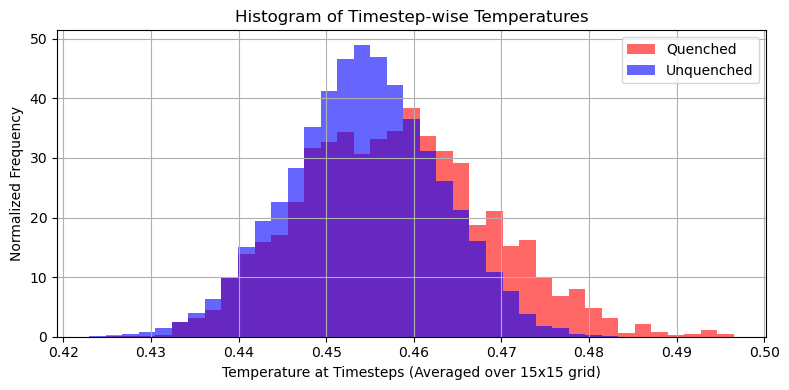

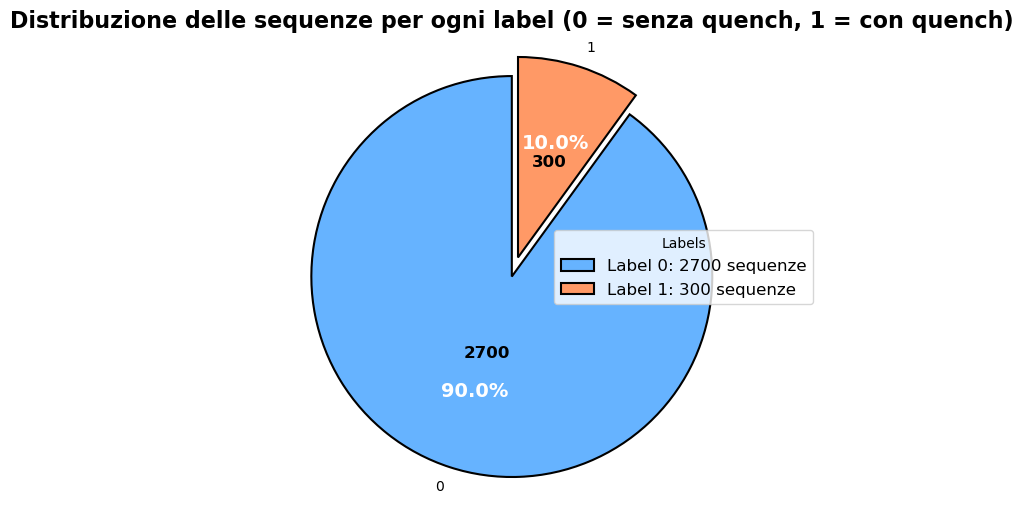

In [81]:
preprocessing.apply_normalization()
preprocessing.more_data_exploration()


In [82]:
data['sequence'][0].shape

(24, 15, 15)

In [83]:
sequenze = np.stack(data['sequence'].values).reshape(-1, 24,15,15)


In [88]:
import pandas as pd
data['sequence']= sequenze.tolist()
data['sequence']=data['sequence'].apply(lambda x: np.array(x))

In [89]:
data['sequence'][0].shape

(24, 15, 15)

In [86]:
dataframe[0].shape

(100,)